In [1]:
import sys
!{sys.executable} -m pip install transformers pillow torch lmdb pydantic pillow

In [2]:
import os
import sys
from importlib import reload
module_path = os.path.abspath(os.path.join('/workspaces/vector_db/jfdb'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from jfdb import hsnw

/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import logging
reload(logging)
logging.basicConfig(
    format='%(name)s:%(levelname)s:%(funcName)s: %(message)s',
    level=logging.INFO
)

db = hsnw.DataBase(
    L=4,
    M=10,
    # m_L=1,  # increase to 1 to force more edges
    d=512,
    M_max=20,
    M_max0=40,
    ef_construction=10,
    # backend=LMDBBackend(
    #     name="another_db",
    #     preallocated_bytes=int(1e6),
    #     node_type=Node,
    #   )
)

transformers.image_processing_base:INFO:get_image_processor_dict: loading configuration file preprocessor_config.json from cache at /home/codespace/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/snapshots/3d74acf9a28c67741b2f4f2ea7635f0aaf6f0268/preprocessor_config.json
transformers.image_processing_utils:INFO:get_size_dict: size should be a dictionary on of the following set of keys: ({'height', 'width'}, {'shortest_edge'}, {'shortest_edge', 'longest_edge'}, {'longest_edge'}, {'max_height', 'max_width'}), got 224. Converted to {'shortest_edge': 224}.
transformers.image_processing_utils:INFO:get_size_dict: crop_size should be a dictionary on of the following set of keys: ({'height', 'width'}, {'shortest_edge'}, {'shortest_edge', 'longest_edge'}, {'longest_edge'}, {'max_height', 'max_width'}), got 224. Converted to {'height': 224, 'width': 224}.
transformers.image_processing_base:INFO:from_dict: Image processor CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "

In [7]:
db.backend.drop_backend()
db.backend.init_backend()

root:INFO:init_backend: Initialized default_db


In [8]:
from jfdb.nodes.node import Node
from jfdb.utils import helpers, datastructures
from PIL import Image
import time

folder_path = '/workspaces/vector_db/images'
timed_inserts = []

# Iterate over files in the folder
for i, filename in enumerate(os.listdir(folder_path)):
  if filename.endswith(('.jpg', '.jpeg', '.png')):  # Check for image files
    file_path = os.path.join(folder_path, filename)
    # try:
    image = Image.open(file_path)
    # Process the image here (e.g., get embedding)
    image_embeddings = helpers.get_embedding_from_image(image, db.processor, db.model)
    node = Node(
        id=filename.split('.')[0],
        layers=db.L,  # TODO: we shouldn't need this
        embedding=image_embeddings[0],
        filepath=filename
    )
    t0 = time.time()
    db.insert(node)
    timed_inserts.append((i, time.time()-t0))

root:INFO:insert: Inserted reshiram
root:INFO:insert: Inserted vivillon-meadow
root:INFO:insert: Inserted typhlosion
root:INFO:insert: Inserted feraligatr
root:INFO:insert: Inserted clefairy
root:INFO:insert: Inserted pumpkaboo-average
root:INFO:insert: Inserted garchomp
root:INFO:insert: Inserted gulpin
root:INFO:insert: Inserted marill
root:INFO:insert: Inserted thundurus-incarnate
root:INFO:insert: Inserted joltik
root:INFO:insert: Inserted emolga
root:INFO:insert: Inserted remoraid
root:INFO:insert: Inserted cobalion
root:INFO:insert: Inserted cradily
root:INFO:insert: Inserted cubchoo
root:INFO:insert: Inserted swanna
root:INFO:insert: Inserted corvisquire
root:INFO:insert: Inserted swablu
root:INFO:insert: Inserted keldeo-ordinary
root:INFO:insert: Inserted eelektross
root:INFO:insert: Inserted incineroar
root:INFO:insert: Inserted ditto
root:INFO:insert: Inserted beartic
root:INFO:insert: Inserted spoink
root:INFO:insert: Inserted umbreon
root:INFO:insert: Inserted bisharp
root:

In [9]:
db.backend.get_percent_full()

0.3710976

root:INFO:search_embedding: Traversed 121 during search


shiinotic 15.039946556091309


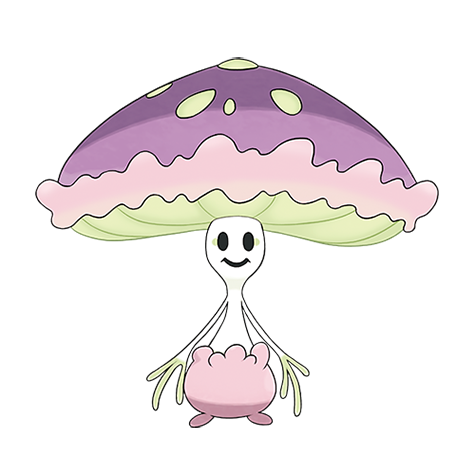

In [17]:
reload(logging)
logging.basicConfig(
    format='%(name)s:%(levelname)s:%(funcName)s: %(message)s',
    level=logging.INFO
)
n, sim = db.search('a yellow mouse with black-tipped ears and red cheeks')
file_path = os.path.join(folder_path, n.filepath)
image = Image.open(file_path)
print(n, sim)
image